In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
# Define improved transformations with better efficiency
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48), antialias=True),  # Add antialias
    transforms.RandomAffine(
        degrees=5,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        fill=0
    ),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))  # Add random erasing
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48), antialias=True),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", transform=transform_train)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", transform=transform_val)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(EmotionCNN, self).__init__()
        
        # Use ModuleList for more efficient layer management
        self.features = nn.ModuleList([
            # First block
            nn.Sequential(
                nn.Conv2d(1, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_rate)
            ),
            # Second block
            nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_rate)
            ),
            # Third block
            nn.Sequential(
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_rate * 1.5)
            )
        ])
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 2),
            nn.Linear(128, 7)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        for layer in self.features:
            x = layer(x)
        x = self.avgpool(x)
        return self.classifier(x)

In [7]:
# Initialize model, loss, and optimizer
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Apply label smoothing
# criterion = FocalLoss(alpha=0.25, gamma=2)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Scheduler setup
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, min_lr=1e-6)

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

@torch.no_grad()
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    return val_loss / len(val_loader), 100. * correct / total

def train_model(model, train_loader, val_loader, epochs=100, accumulation_steps=2):
    print("Starting training...")
    
    # Initialize trackers for loss/accuracy
    best_val_acc = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        
        # Training loop with gradient accumulation
        optimizer.zero_grad()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps
            
            # Backward pass with gradient accumulation
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Free up memory
            del outputs, loss
            torch.cuda.empty_cache()
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}\n')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses
print("Starting training...")
train_model(model, loaded_train, loaded_validation, epochs=100)
print("Training complete!")

Starting training...
Starting training...


C:\Users\shane_1\AppData\Local\Temp\ipykernel_2220\2108012693.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\shane_1\AppData\Local\Temp\ipykernel_2220\2108012693.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/100:
Train Loss: 1.7882, Train Acc: 26.81%
Val Loss: 1.9348, Val Acc: 26.83%
LR: 0.000500

Epoch 2/100:
Train Loss: 1.6040, Train Acc: 38.78%
Val Loss: 1.4753, Val Acc: 45.29%
LR: 0.000500

Epoch 3/100:
Train Loss: 1.4885, Train Acc: 44.95%
Val Loss: 1.4092, Val Acc: 48.92%
LR: 0.000500

Epoch 4/100:
Train Loss: 1.4203, Train Acc: 48.42%
Val Loss: 1.3731, Val Acc: 49.86%
LR: 0.000500

Epoch 5/100:
Train Loss: 1.3731, Train Acc: 50.85%
Val Loss: 1.3569, Val Acc: 52.22%
LR: 0.000500

Epoch 6/100:
Train Loss: 1.3416, Train Acc: 52.16%
Val Loss: 1.3208, Val Acc: 52.99%
LR: 0.000500

Epoch 7/100:
Train Loss: 1.3124, Train Acc: 53.80%
Val Loss: 1.2304, Val Acc: 56.57%
LR: 0.000500

Epoch 8/100:
Train Loss: 1.2926, Train Acc: 54.77%
Val Loss: 1.2505, Val Acc: 56.51%
LR: 0.000500

Epoch 9/100:
Train Loss: 1.2718, Train Acc: 55.70%
Val Loss: 1.2241, Val Acc: 58.18%
LR: 0.000500

Epoch 10/100:
Train Loss: 1.2565, Train Acc: 56.64%
Val Loss: 1.2065, Val Acc: 58.22%
LR: 0.000500

Epoch 11/

Target label: fear


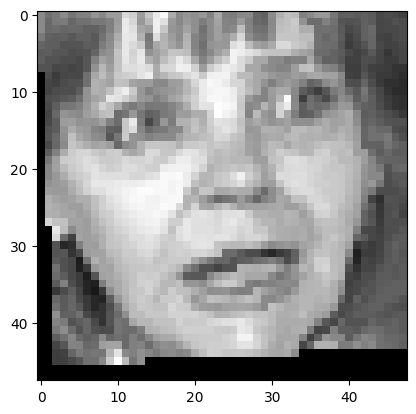

In [8]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


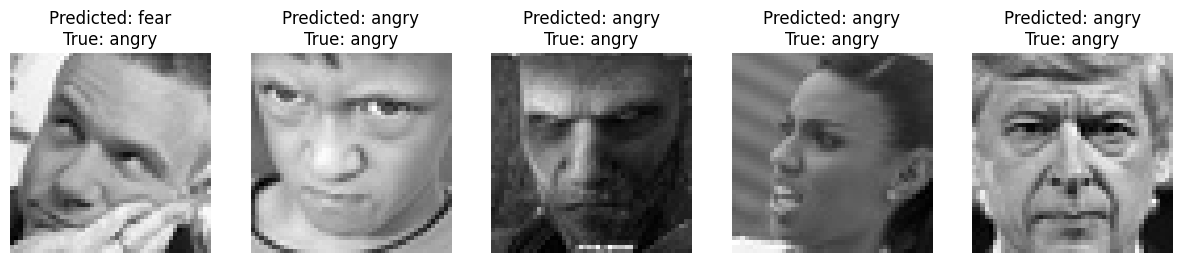

In [9]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()